The purpose of this example is to show how to use this package to study the attenuation of photons in a material.

We define a very simple geometry: a target volume made of lead is protected by a shielding volume, whose material can be set by the user.
Photons are launched towards the target, protected by the shielding. The thickness of the shielding can be set by the user.
If there is some energy left on the target, we consider that the shielding has failed to block the incident particles.
We compute the ratio of events reaching the target, and we plot it as a function of the thickness of the shielding.

In [1]:
from __future__ import annotations

from concurrent.futures import ThreadPoolExecutor

import numpy as np
from IPython.display import clear_output


def construct_geometry_gdml(material: str, thickness_mm: float):
    return Rf"""<?xml version="1.0" encoding="utf-8" standalone="no" ?>
    <gdml xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
          xsi:noNamespaceSchemaLocation="http://service-spi.web.cern.ch/service-spi/app/releases/GDML/schema/gdml.xsd">
    
        <define>
            <constant name="worldSize" value="1000"/>
            <constant name="size_XY_mm" value="100"/>\
            <constant name="target_thickness_mm" value="100"/>
        </define>
    
        <solids>
            <box name="world_solid" x="size_XY_mm" y="size_XY_mm" z="{thickness_mm} * 2 + target_thickness_mm * 2" lunit="mm"/>\
            
            <box name="shielding_solid" x="size_XY_mm" y="size_XY_mm" z="{thickness_mm}" lunit="mm"/>\
            <box name="target_solid" x="size_XY_mm" y="size_XY_mm" z="target_thickness_mm" lunit="mm"/>
        </solids>
    
        <structure>
            <volume name="shielding_volume">
                <materialref ref="{material}"/>
                <solidref ref="shielding_solid"/>
            </volume>
    
            <volume name="target_volume">
                <materialref ref="G4_Pb"/>
                <solidref ref="target_solid"/>
            </volume>
            
            <volume name="World">
                <materialref ref="G4_AIR"/>
                <solidref ref="world_solid"/>
    
                <physvol name="target">
                    <volumeref ref="target_volume"/>
                    <position name="target_position" unit="mm" x="0" y="0" z="target_thickness_mm/2"/>
                </physvol>
    
                <physvol name="shielding">
                    <volumeref ref="shielding_volume"/>
                    <position name="shielding_position" unit="mm" x="0" y="0" z="{-0.5 * thickness_mm}"/>
                </physvol>
            </volume>
        </structure>
    
        <setup name="Default" version="1.0">
            <world ref="World"/>
        </setup>
    </gdml>
    """

In [2]:
from geant4_python_application import Application, install_datasets

# The python package does not come with the Geant4 datasets, so we need to install them.
# If a compatible Geant4 installation is available, the package will attempt to use these datasets.
# It is not necessary to manually install the datasets, if they are found to be missing, the package will attempt to install them.

install_datasets()

In [3]:
geometry = construct_geometry_gdml(material="G4_Pb", thickness_mm=10)

with Application(gdml=geometry) as app:
    app.command("/gun/particle gamma")
    app.command("/gun/energy 477.6 keV")
    app.command("/gun/direction 0 0 1")
    app.command("/gun/position 0 0 -1 m")

    events = app.run(100)

clear_output(wait=True)


**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

G4GDML: Reading '/tmp/geant4_python_application/gdml/GDML_4215535847.gdml'...
G4GDML: Reading definitions...
G4GDML: Reading solids...
G4GDML: Reading structure...
G4GDML: Reading setup...
G4GDML: Reading '/tmp/geant4_python_application/gdml/GDML_4215535847.gdml' done!
Stripping off GDML names of materials, solids and volumes ...
======                 Electromagnetic Physics Parameters      ========
LPM effect enabled                                 1
Enable creation and use of sampling tables         0
A

In [4]:
# Explore the structure of the event data
events.type.show()

100 * Geant4Event[
    run: uint32,
    id: uint32,
    primaries: var * Geant4Primaries[
        particle: string,
        energy: float64,
        position: Vector3D[
            x: float64,
            y: float64,
            z: float64
        ],
        direction: Momentum3D[
            px: float64,
            py: float64,
            pz: float64
        ]
    ],
    track: Geant4Track[
        id: var * uint32,
        parent_id: var * uint32,
        initial_energy: var * float64,
        initial_time: var * float64,
        initial_position: var * Vector3D[
            x: float64,
            y: float64,
            z: float64
        ],
        particle: var * string,
        creator_process: var * string,
        step: Geant4Step[
            energy: var * var * float64,
            time: var * var * float64,
            process: var * var * string,
            volume: var * var * string,
            position: var * var * Vector3D[
                x: float64,
              

In [5]:
from geant4_python_application import install_datasets

install_datasets()

thicknesses = np.logspace(0, 2, 50)
ratios = np.zeros(len(thicknesses))
ratios_error = np.zeros(len(thicknesses))


def compute(i: int):
    thickness = thicknesses[i]
    geometry = construct_geometry_gdml(material="G4_Pb", thickness_mm=thickness)

    with Application(gdml=geometry) as app:
        app.command("/gun/particle gamma")
        app.command("/gun/energy 477.6 keV")
        app.command("/gun/direction 0 0 1")
        app.command("/gun/position 0 0 -1 m")

        max_total_count = 100000

        total_counts = 0
        valid_counts = 0

        while total_counts < max_total_count:
            # batch size can be adjusted to optimize performance
            events = app.run(5000)
            total_counts += len(events)
            valid_counts += np.sum(events.energy_in_volume("target") > 0)
            # check if relative error is below 1%
            if valid_counts > 0 and np.sqrt(valid_counts) / valid_counts < 0.01:
                break

        ratios[i] = valid_counts / total_counts

        if valid_counts > 0:
            # add some upper limit to the error (68% confidence level)
            ratios_error[i] = np.sqrt(valid_counts) / total_counts
        else:
            ratios_error[i] = 1.14 / total_counts


# We can compute in parallel, with each simulation running in a separate thread.
# The light-weight threads spawn a process that runs the simulation, so this will benefit from multi-core CPUs.
# Each simulation might be memory hungry, so we should not run too many in parallel.
# Geant4 has built-in parallelism, but it cannot be used for this particular case, as each simulation has its own geometry.
with ThreadPoolExecutor(max_workers=8) as executor:
    # we compute in reverse order as the simulations with larger thicknesses will take longer
    executor.map(compute, reversed(range(len(thicknesses))))

for i in range(len(thicknesses)):
    ...
    # compute(i) # alternatively, we could compute sequentially


clear_output(wait=True)

for thickness, ratio, ratio_error in zip(thicknesses, ratios, ratios_error):
    print(f"Thickness: {thickness:0.3e} mm, ratio: {ratio:0.3e} ± {ratio_error:0.3e}")

# Beware! The stdout may be too long that it can apparently corrupt the notebook file, it may be a good idea to clear the cell output before saving the notebook.

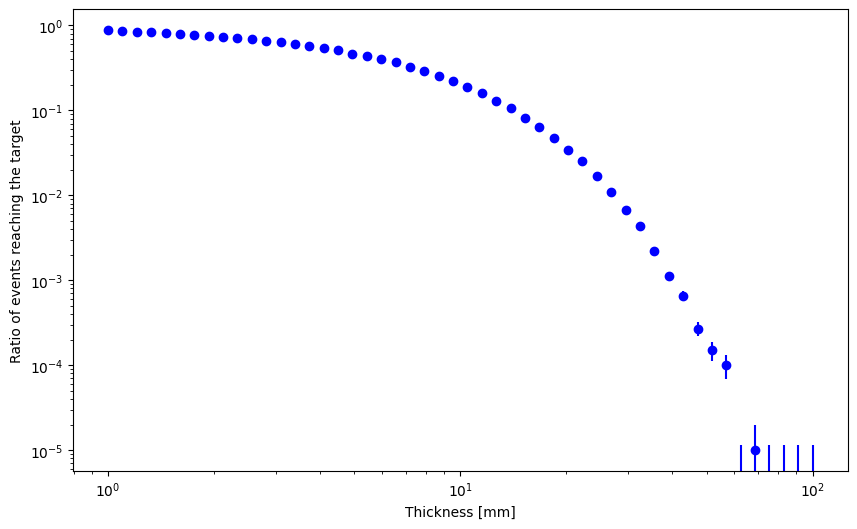

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.errorbar(thicknesses, ratios, yerr=ratios_error, fmt="o", color="blue")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Thickness [mm]")
plt.ylabel("Ratio of events reaching the target")

plt.show()

In [7]:
def find_thickness(ratio_stop: float):
    # ratio_stop is the fraction of particles that we want to block e.g. 0.999
    if not 0 < ratio_stop < 1:
        raise ValueError("ratio_stop should be between 0 and 1")

    ratio_min = 1 - ratio_stop
    for thickness, ratio, ratio_error in zip(thicknesses, ratios, ratios_error):
        if ratio < ratio_min + ratio_error:
            return thickness


print(f"Thickness to block 90% of the particles: {find_thickness(0.9):0.3e} mm")
print(f"Thickness to block 99% of the particles: {find_thickness(0.99):0.3e} mm")
print(f"Thickness to block 99.9% of the particles: {find_thickness(0.999):0.3e} mm")
print(f"Thickness to block 99.99% of the particles: {find_thickness(0.9999):0.3e} mm")
print(f"Thickness to block 99.999% of the particles: {find_thickness(0.99999):0.3e} mm")
print(
    f"Thickness to block 99.9999% of the particles: {find_thickness(0.999999):0.3e} mm"
)
print(
    f"Thickness to block 99.99999% of the particles: {find_thickness(0.9999999):0.3e} mm"
)
print(
    f"Thickness to block 99.999999% of the particles: {find_thickness(0.99999999):0.3e} mm"
)

Thickness to block 90% of the particles: 1.526e+01 mm
Thickness to block 99% of the particles: 2.947e+01 mm
Thickness to block 99.9% of the particles: 4.292e+01 mm
Thickness to block 99.99% of the particles: 5.690e+01 mm
Thickness to block 99.999% of the particles: 6.251e+01 mm
Thickness to block 99.9999% of the particles: 6.251e+01 mm
Thickness to block 99.99999% of the particles: 6.251e+01 mm
Thickness to block 99.999999% of the particles: 6.251e+01 mm
